# Expectation Propagation

ForneyLab comes with support for expectation propagation (EP). In this demo we illustrate EP in the context of state-estimation in a linear state-space model that combines a Gaussian state-evolution model with a discrete observation model. Here, the probit sigmoid function links continuous variable `x_t` with the discrete variable `y_t`. The model is defined as:

\begin{align*}
    u &= 0.1\\
    x_0 &\sim \mathcal{N}(0, 100)\\
    x_t &\sim \mathcal{N}(x_{t-1} + u, 0.01)\\
    y_t &\sim \mathcal{B}er(\sigma(x_t))
\end{align*}

The FFG representation of this model consists of a concatenation of the following sections (one per timestep):

```
              (u)   (0.01)
               |      |
               v      v
(x_t_min) ---> + --->[N]---> = ---> (x_t)
                             |
                            [σ]
                             | 
                           (y_t)
```

In [1]:
using SpecialFunctions

# Generate data set
srand(123)
n_samples = 40
σ(x) = 0.5 + 0.5*erf.(x./sqrt(2))

u_data = 0.1
x_data = []
y_data = []
x_prev = -2.0
for t=1:n_samples
    push!(x_data, x_prev + u_data + sqrt(0.01)*randn()) # State transition
    push!(y_data, σ(x_data[end]) > rand()); # Observation
    x_prev = x_data[end]
end

# Model specification

In [2]:
using ForneyLab

g = FactorGraph()

# State prior
@RV x_0 ~ GaussianMeanVariance(0.0, 100.0)

x = Vector{Variable}(n_samples)
d = Vector{Variable}(n_samples)
y = Vector{Variable}(n_samples)
x_t_min = x_0
for t = 1:n_samples
    @RV d[t] ~ GaussianMeanVariance(u_data, 0.01)
    @RV x[t] = x_t_min + d[t]
    @RV y[t] ~ Sigmoid(x[t])

    # Data placeholder
    placeholder(y[t], :y, index=t)
    
    # Reset state for next step
    x_t_min = x[t]
end

# Algorithm generation

With the model defined, we can now generate an EP algorithm. The EP algorithm requires initial messages. To automatically populate the messages array with inital messages, an `init()` function is generated. The EP algorithm is executed by calling `init()` once, and then calling `step!(...)` repeatedly until convergence.

In [3]:
algo = expectationPropagationAlgorithm(x)

println(algo)

begin

function init()

messages = Array{Message}(277)
messages[244] = Message(vague(GaussianWeightedMeanPrecision))
messages[253] = Message(vague(GaussianWeightedMeanPrecision))
messages[219] = Message(vague(GaussianWeightedMeanPrecision))
messages[197] = Message(vague(GaussianWeightedMeanPrecision))
messages[273] = Message(vague(GaussianWeightedMeanPrecision))
messages[265] = Message(vague(GaussianWeightedMeanPrecision))
messages[269] = Message(vague(GaussianWeightedMeanPrecision))
messages[234] = Message(vague(GaussianWeightedMeanPrecision))
messages[272] = Message(vague(GaussianWeightedMeanPrecision))
messages[238] = Message(vague(GaussianWeightedMeanPrecision))
messages[203] = Message(vague(GaussianWeightedMeanPrecision))
messages[259] = Message(vague(GaussianWeightedMeanPrecision))
messages[225] = Message(vague(GaussianWeightedMeanPrecision))
messages[222] = Message(vague(GaussianWeightedMeanPrecision))
messages[247] = Message(vague(GaussianWeightedMeanPrecision))
messages[191] =

# Execution

In [4]:
eval(parse(algo));

In [5]:
messages = init()
marginals = Dict()
data = Dict(:y => y_data)

n_its = 4*n_samples
for i = 1:n_its
   step!(data, marginals, messages)
end

# Results

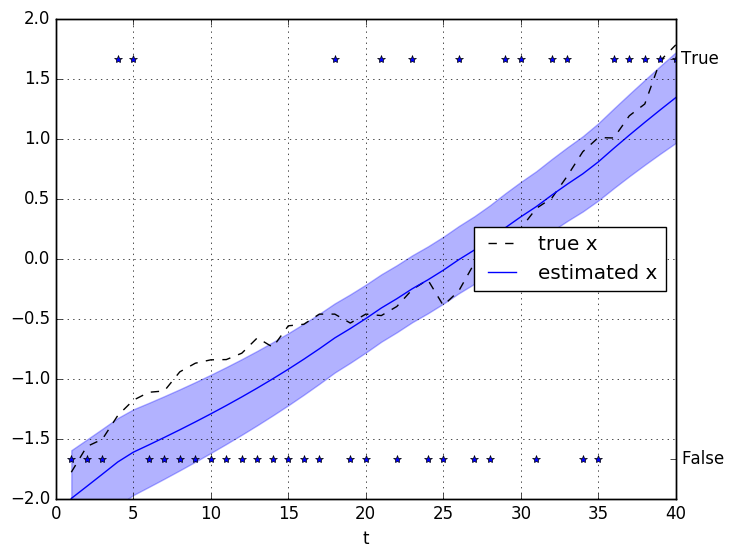

In [6]:
using PyPlot

# Extract posterior statistics
m_x = [mean(marginals[:x_*t]) for t = 1:n_samples]
v_x = [var(marginals[:x_*t]) for t = 1:n_samples]

plot(collect(1:n_samples), x_data, "k--", label="true x")
plot(collect(1:n_samples), m_x, "b-", label="estimated x")
fill_between(collect(1:n_samples), m_x-sqrt.(v_x), m_x+sqrt.(v_x), color="b", alpha=0.3);
grid("on")
xlabel("t")
xlim(1, n_samples)
ylim(-2, 2)
legend(loc=7)

ax = gca()
ax[:twinx]()
plot(collect(1:n_samples), y_data, "b*", label="y")
yticks([0.0, 1.0], ["False", "True"]);
ylim(-0.1, 1.1);